In [3]:
import numpy as np
import pandas as pd
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
from datetime import date,datetime
from dateutil.relativedelta import relativedelta
ticks = ['XLB','XLI','XLY','XLP', 'XLE','XLF','XLU','XLV','XLK']
end = date.today()
beg = end - relativedelta(years = 10)

In [5]:
data = pd.DataFrame(yf.download(ticks, start=beg, end=end)['Adj Close'])

[*********************100%***********************]  9 of 9 downloaded


In [6]:
#lets calc returns and cov matrix
rets = np.log(1+data.pct_change()).dropna()
mean_rets = rets.mean()*252
cov = rets.cov()*252
syms = len(ticks)


In [7]:
##now we simulate the returns of the portfolio across random samples
prets = []
pvols = []

for trial in range(20000):
    weights = np.random.random(syms)
    weights /= np.sum(weights)
    prets.append(np.sum(mean_rets*weights))
    pvols.append(np.sqrt(np.dot(weights.T,
                                np.dot(cov,weights))))
prets = np.array(prets)
pvols = np.array(pvols)

In [8]:
#function for computing portfolio returns, std, and shapre
def port_stats(weights):
    w = np.array(weights)
    r = np.sum(w*mean_rets)
    std = np.sqrt(np.dot(w.T,np.dot(cov,w)))
    sharpe = r/std
    return np.array([r,std,sharpe])

In [9]:
import scipy.optimize as sco
#boundaries
bnds = tuple((0,.3) for x in range(syms))
#constraints
cons = ({'type':'eq','fun':lambda x: np.sum(x)-1})

#returns negative of sharpe b/c minimum of negative sharpe is the maximum of the sharpe ratio
def max_sharpe(weights):
    return -port_stats(weights)[2]

guess = syms*[1/syms]
sharpe_opt = sco.minimize(max_sharpe, guess, method = 'SLSQP',constraints=cons, bounds=bnds)

#now lets find the min variance portfolio

def min_var(weights):
    return port_stats(weights)[1]

min_var_opt = sco.minimize(min_var, guess, method = 'SLSQP',constraints=cons, bounds=bnds)


In [10]:
#now lets create an efficient frontier for this dataset
frets = np.linspace(0.06, .13, 50)
fvols = []
for ret in frets:
    cons = ({'type':'eq', 'fun':lambda x: port_stats(x)[0]-ret},
            {'type':'eq','fun':lambda x: np.sum(x)-1})
    res = sco.minimize(min_var, guess, constraints = cons, bounds = bnds, method ='SLSQP')
    fvols.append(res['fun']) ## this is the actual vol
fvols = np.array(fvols)

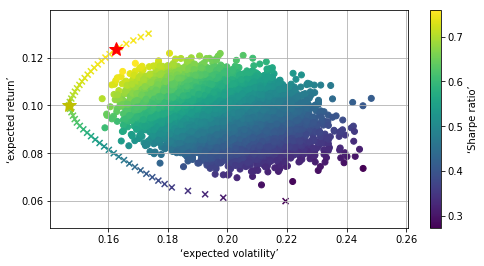

In [11]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
c=prets / pvols, marker='o')
# random portfolio composition
plt.scatter(fvols, frets,
c=frets / fvols, marker='x')
# efficient frontier
plt.plot(port_stats(sharpe_opt['x'])[1], port_stats(sharpe_opt['x'])[0],
'r*', markersize=15.0)
# portfolio with highest Sharpe ratio
plt.plot(port_stats(min_var_opt['x'])[1], port_stats(min_var_opt['x'])[0],
'y*', markersize=15.0)
# minimum variance portfolio
plt.grid(True)
plt.xlabel('‘expected volatility’')
plt.ylabel('‘expected return’')
plt.colorbar(label='‘Sharpe ratio’')

In [12]:
import scipy.interpolate as sci
##this code starts the interpolation at the minvar Portfolion
ind = np.argmin(fvols)
evols = fvols[ind:]
erets = frets[ind:]
tck = sci.splrep(evols, erets)

In [13]:
#define function
def f(x):
    return sci.splev(x,tck,der=0)
def df(x):
    return sci.splev(x,tck,der=1)

def CAPM_eq(p,rf=0.0175):
    eq1 = rf - p[0]
    eq2 = rf + p[1]*p[2]-f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1,eq2,eq3

#solivng the CAPM equation
CAPM_opt = sco.fsolve(CAPM_eq,[.0175,.5,.15])
CAPM_opt

array([0.0175    , 0.65177943, 0.16397355])

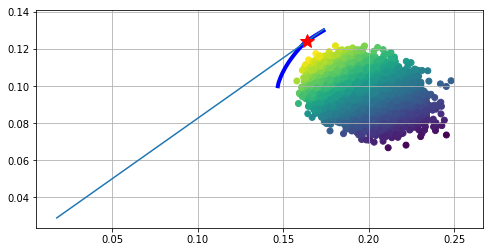

In [14]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
c=(prets - 0.01) / pvols, marker='o')
# random portfolio composition
plt.plot(evols, erets, 'b', lw=4.0)
rang = np.linspace(.0175,.174)
plt.plot(rang, CAPM_opt[0] + CAPM_opt[1]*rang)
plt.plot(CAPM_opt[2], f(CAPM_opt[2]), 'r*', markersize=15.0)
plt.grid(True)

In [36]:
#lets mess around with a rolling optimization portfolio
monthly_bm = pd.DataFrame(yf.download('BRK-B', start=beg, end=end)['Adj Close'])
monthly_bm = monthly_bm.resample('BM').asfreq().ffill()
monthly_bm = np.log(1+monthly_bm.pct_change()).dropna()
monthly_bm.columns = ['Brk-B']
monthly = data.resample('BM').asfreq().ffill()
monthly = np.log(1+monthly.pct_change()).dropna()


[*********************100%***********************]  1 of 1 downloaded


In [42]:
lookback = 12
def quadfit(train,trainBM,test,testBM):
    syms = train.shape[1]
    #boundaries
    bnds = tuple((0,.5) for x in range(syms))
    #constraints
    cons = ({'type':'eq','fun':lambda x: np.sum(x)-1})
    guess = syms*[1/syms]
    
    #now lets find the min variance portfolio
    train_rets = train.mean()*12
    train_cov = train.cov()*12
    def port_stats(weights):
        w = np.array(weights)
        r = np.sum(w*train_rets)
        std = np.sqrt(np.dot(w.T,np.dot(train_cov,w)))
        sharpe = r/std
        return np.array([r,std,sharpe])
    def max_sharpe(weights):
        return -port_stats(weights)[2]
    sharpe_opt = sco.minimize(max_sharpe, guess, method = 'SLSQP',constraints=cons, bounds=bnds)
    weights = sharpe_opt['x']
    test_rets = np.dot(weights,test)
    test_rets_bm = testBM
    cols = ticks+['Port Returns']+['Brk-B Returns']
    arr = np.hstack([weights,np.array(test_rets),test_rets_bm]).reshape(1,11)
    result = pd.DataFrame(arr,columns=cols)
    return result

In [43]:
minsim = lookback
maxsim = monthly.shape[0]

for sim in range(minsim,maxsim):
    train = monthly.iloc[sim-lookback:sim]
    train_bm = monthly_bm.iloc[sim-lookback:sim]
    test = monthly.iloc[sim]
    test_bm = monthly_bm.iloc[sim]
    result = quadfit(train,train_bm,test,test_bm)
    if sim == minsim:
        backtestWeights = result[ticks]
        backtestReturns = result[['Port Returns', 'Brk-B Returns']]
    else:
        backtestWeights = backtestWeights.append(result[ticks])
        backtestReturns = backtestReturns.append(result[['Port Returns', 'Brk-B Returns']])
    

,XLB,XLI,XLY,XLP,XLE,XLF,XLU,XLV,XLK
0,5.736152e-16,4.267017e-16,8.786303e-18,0.000000e+00,5.000000e-01,0.000000e+00,3.150308e-16,2.324529e-16,5.000000e-01
0,1.192102e-14,5.754861e-15,7.199406e-15,5.440018e-15,5.000000e-01,3.017415e-15,2.512616e-15,0.000000e+00,5.000000e-01
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,4.424695e-01,5.753052e-02
0,1.685754e-01,1.020747e-01,3.204391e-12,2.687640e-12,5.000000e-01,1.906285e-12,1.747438e-12,2.293500e-01,2.070911e-11
0,2.651163e-15,0.000000e+00,1.235831e-15,1.996572e-15,5.000000e-01,3.649276e-01,1.191606e-15,0.000000e+00,1.350724e-01
0,0.000000e+00,0.000000e+00,0.000000e+00,6.618585e-16,0.000000e+00,5.000000e-01,0.000000e+00,3.516325e-01,1.483675e-01
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,3.402010e-01,1.597990e-01
0,1.572134e-13,0.000000e+00,8.384732e-15,1.026555e-12,6.620468e-14,5.000000e-01,9.196878e-15,1.060582e-01,3.939418e-01
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.684652e-01,0.000000e+00,3.153478e-02,5.000000e-01
